In [2]:
# !pip install torch-geometric \
#   torch-sparse==latest+cu101 \
#   torch-scatter==latest+cu101 \
#   torch-cluster==latest+cu101 \
#   -f https://pytorch-geometric.com/whl/torch-1.4.0.html

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import EdgeConv

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Load Data From JSON

In [5]:
import json
data_0 = {}
with open('/home/subella/src/cog-rob-multi-agent-prediction-project/data/data.json') as json_file:
    data_0 = json.load(json_file)

# data_1 = {}
# with open('data_1.json') as json_file:
#     data_1 = json.load(json_file)

In [6]:
import math
from itertools import combinations
from itertools import permutations
from torch_geometric.data import Data

def encode_label(label):
  temp = ["IGNORING", "GOING", "YIELDING"]
  encode = [0] * 3
  encode[temp.index(label)] = 1
  return encode

def generate_node_feature_tensor(data_window):
    """
    Transform the simulated data into a node tensor encoding five previous 
    timesteps and features are x, y, v_x, and v_y for every given node in out
    system

    Input: 
      generated_data - a list of state dictionaries  for every vehicle in the
                       the graph
    Output: A PyTorch tensor with dimensioanlity (#Node, 5, 4)
    """

    time_window = len(data_window)
    agent_count = len(data_window[0]["agents"])
    node_feature_tensor = torch.zeros((agent_count, time_window, 4))
    for node_idx in range(agent_count):
      for time in range(time_window):
        node_feature_tensor[node_idx][time][0] = data_window[time]["agents"][node_idx]["state"][0]
        node_feature_tensor[node_idx][time][1] = data_window[time]["agents"][node_idx]["state"][1]
        node_feature_tensor[node_idx][time][2] = data_window[time]["agents"][node_idx]["state"][2]
        node_feature_tensor[node_idx][time][3] = data_window[time]["agents"][node_idx]["state"][3]
    
    return node_feature_tensor

def generate_edge_feature_tensor(data,label_data):
    """
    Transform the simulated data into a node tensor encoding five previous 
    timesteps and features are x, y, v_x, and v_y for every given node in out
    system

    Input: 
      generated_data - a list of state dictionaries  for every vehicle in the
                       the graph
    Output: A PyTorch tensor with dimensioanlity (#Node, 5, 4)
    """

    agent_count = len(data)
    edge_feature_tensor = torch.zeros((math.factorial(agent_count),4))
    edge_list = torch.zeros((math.factorial(agent_count),2))
    labels = []

    combination_agents = permutations(data,2)
    for i, agent_pair in enumerate(combination_agents):
      from_node, to_node = agent_pair
      from_node_id, to_node_id = from_node["agent_id"], to_node["agent_id"]
      edge_list[i][0] = from_node_id
      edge_list[i][1] = to_node_id
      labels.append(encode_label(label_data[from_node_id][to_node_id]))

      edge_feature_tensor[i][0] = from_node["state"][0] - to_node["state"][0]
      edge_feature_tensor[i][1] = from_node["state"][1] - to_node["state"][1]
      edge_feature_tensor[i][2] = from_node["state"][2] - to_node["state"][2]
      edge_feature_tensor[i][3] = from_node["state"][3] - to_node["state"][3]
    
    labels = torch.tensor(labels)
    return edge_feature_tensor, edge_list, labels


def sequence_node_data(data):
    node_data = []
    for t in range(4,len(data)):
      data_window = data[t-4:t+1]
      tensor = generate_node_feature_tensor(data_window)
      node_data.append(tensor)
    return node_data

def sequence_edge_data(data):
    edge_data = []
    edge_list_data = []
    labels = []
    for time in data:
      tensor,edge_list,label = generate_edge_feature_tensor(time["agents"],time["labels"])
      edge_data.append(tensor)
      edge_list_data.append(edge_list)
      labels.append(label)
    # print(len(labels), labels[0].shape)
    return edge_data,edge_list_data,labels


def create_joined_data_array(data):
  edge_features_data_list,edges,edge_labels = sequence_edge_data(data["data"])
  edge_labels = edge_labels[4:]
  edge_features_data_list = edge_features_data_list[4:]
  node_features_data_list = sequence_node_data(data["data"])
  joined_data = []
  for i in range(len(edge_features_data_list)):
    data_point = Data(x=node_features_data_list[i], edge_index=edges[0], edge_attr=edge_features_data_list[i],y=edge_labels[i])
    joined_data.append(data_point)
  return joined_data

In [7]:
final_data = create_joined_data_array(data_0)

# RNN


In [ ]:
class PastStateEncoder(nn.Module):
    def __init__(self, output_size, timesteps, features):
      super().__init__()
      self.output_size = output_size
      self.embedding = nn.Embedding(timesteps, features)
      self.conv = nn.Conv1d(features*2,output_size,3,1,1)

    def forward(self, x):
      B, L, H = x.shape
      pos = torch.arange(L)
      x = torch.cat([x, self.embedding(pos).view(1, L, 4).expand(B, L, 4)], dim=-1)
      x = x.transpose(2,1)
      return self.conv(x).mean(dim=-1)

In [ ]:
x = torch.FloatTensor(2,5,4)
enc = PastStateEncoder(128, 5, 4)
enc(x).shape

torch.Size([2, 128])

# GNN Model


## Create 2 Layer GNN Block

In [ ]:
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer

class EdgeModel(torch.nn.Module):
    def __init__(self,num_features_in,edge_features_in):
        super().__init__()
        self.edge_mlp = nn.Sequential(nn.Linear(2 * num_features_in + edge_features_in , 256),
                       nn.ReLU(),
                       nn.Linear(256, 128))

    def forward(self, src, dest, edge_attr, u, batch):
        # src, dest: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        # print(src.shape, "THIS IS SRC")
        # print(dest.shape, "THIS IS dest")
        # print(edge_attr.shape, "THIS IS edge_attr")
        out = torch.cat([src, dest, edge_attr], 1)
        out = self.edge_mlp(out)
        return out

class NodeModel(torch.nn.Module):
    def __init__(self,num_features_in, edge_features_in):
        super().__init__()
        self.node_mlp_1 = nn.Sequential(nn.Linear(2*num_features_in, 256),
                       nn.ReLU(),
                       nn.Linear(256, 128))

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        return self.node_mlp_1(out) 

def get_meta_gcn(num_features_in,edge_features_in):
  return MetaLayer(edge_model=EdgeModel(num_features_in,edge_features_in), node_model=NodeModel(num_features_in,edge_features_in))

# Create Full Stack

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.rnn = PastStateEncoder(128, 5, 4)
        # self.linear = nn.Linear(4,128)
        self.gnn1 = get_meta_gcn(128,4)
        self.gnn2 = get_meta_gcn(128,128)
        self.mlp = nn.Sequential(nn.Linear(128, 128),
                       nn.ReLU(),
                       nn.Linear(128, 3))
    def forward(self, data):
        x = self.rnn(data.x)
        new_x,new_edge_attrb,new_global = self.gnn1(x, data.edge_index.type(torch.LongTensor), data.edge_attr, None, data.batch )
        new_x,new_edge_attrb,new_global= self.gnn2(new_x, data.edge_index.type(torch.LongTensor), new_edge_attrb, None, data.batch)
        logits = self.mlp(new_edge_attrb)
        return F.softmax(logits, dim=1)

## Creata Dataloder

In [ ]:
from torch_geometric.data import InMemoryDataset, download_url
class MyDataset(InMemoryDataset):
    def __init__(self, root, data_list, transform=None):
        self.data_list = data_list
        super().__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return 'data.pt'

    def process(self):
        torch.save(self.collate(self.data_list), self.processed_paths[0])

In [ ]:
final_data_0 = create_joined_data_array(data_0)
final_data_1 = create_joined_data_array(data_1)
final_data_joined = final_data_0 + final_data_1
dataset = MyDataset("",final_data_joined)
loader = DataLoader(final_data_joined)


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Train & Evaluate

In [ ]:
from numpy.lib.function_base import gradient
import pdb
from tqdm import tqdm
def train(model, optimizer, loader, total, batch_size, leave=False):
    model.train()
    xentropy = nn.CrossEntropyLoss(weight=torch.tensor([0.042, 1.0, 1.0]),reduction='sum')
    sum_loss = 0.
    t = tqdm(enumerate(loader), total=total/batch_size, leave=leave)
    for i, data in t:
        data = data.to(device)
        y = torch.tensor(data.y)
        optimizer.zero_grad()
        batch_output = model(data)
        batch_loss = xentropy(batch_output, y.type(torch.FloatTensor))
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()    
    return sum_loss/(i+1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)
batch_size = 32
total = len(final_data_joined)
# train(model,optimizer,loader,total, batch_size)

In [ ]:
def test(model, loader, total, batch_size, leave=False):
    model.eval()
    xentropy = nn.CrossEntropyLoss(weight=torch.tensor([0.042, 1.0, 1.0]),reduction='sum')
    sum_loss = 0.
    t = tqdm(enumerate(loader), total=total/batch_size, leave=leave)
    for i, data in t:
        data = data.to(device)
        y = torch.argmax(data.y, dim=1)
        batch_output = model(data)
        batch_loss_item = xentropy(batch_output, y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update
    return sum_loss/(i+1)

In [ ]:
from torch_geometric.data import Data, DataListLoader, Batch
from torch.utils.data import random_split

def collate(items):
    l = sum(items, [])
    return Batch.from_data_list(l)

torch.manual_seed(0)
valid_frac = 0.20
full_length = len(final_data_joined)
valid_num = int(valid_frac*full_length)
batch_size = 32

train_dataset, valid_dataset = random_split(final_data_joined, [full_length-valid_num,valid_num])

train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(final_data_joined, batch_size=batch_size, pin_memory=True, shuffle=False)


train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(final_data_joined)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
import os.path as osp

n_epochs = 15
stale_epochs = 0
best_valid_loss = 99999
patience = 5
t = tqdm(range(0, n_epochs))

for epoch in t:
    loss = train(model, optimizer, train_loader, train_samples, batch_size, leave=bool(epoch==n_epochs-1))
    valid_loss = test(model, valid_loader, valid_samples, batch_size, leave=bool(epoch==n_epochs-1))
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('           Validation Loss: {:.4f}'.format(valid_loss))
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('interactionnetwork_best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

  0%|          | 0/15 [00:00<?, ?it/s]
  0%|          | 0/165.625 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()

loss = 21.79282:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 21.79282:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 17.56261:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 17.56261:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 21.63617:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 21.63617:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 21.63617:   2%|▏         | 3/165.625 [00:00<00:05, 29.71it/s]
loss = 19.47987:   2%|▏         | 3/165.625 [00:00<00:05, 29.71it/s]
loss = 19.47987:   2%|▏         | 3/165.625 [00:00<00:05, 29.71it/s]
loss = 25.59582:   2%|▏  

Epoch: 00, Training Loss:   14.0147
           Validation Loss: 11.5018
New best model saved to: interactionnetwork_best.pth



  0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 11.08233:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 11.08233:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 7.72429:   0%|          | 0/165.625 [00:00<?, ?it/s] 
loss = 7.72429:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 7.72429:   1%|          | 2/165.625 [00:00<00:08, 18.88it/s]
loss = 15.75805:   1%|          | 2/165.625 [00:00<00:08, 18.88it/s]
loss = 15.75805:   1%|          | 2/165.625 [00:00<00:08, 18.88it/s]
loss = 8.06087:   1%|          | 2/165.625 [00:00<00:08, 18.88it/s] 
loss = 8.06087:   1%|          | 2/165.625 [00:00<00:08, 18.88it/s]
loss = 18.25308:   1%|          | 2/165.625 [00:00<00:08, 18.88it/s]
loss = 18.25308:   1%|          | 2/165.625 [00:00<00:08, 18.88it/s]
loss = 18.25308:   3%|▎         | 5/165.625 [00:00<00:07, 22.16it/s]
loss = 15.27402:   3%|▎         | 5/165.625 [00:00<00:07, 22.16it/s]
loss = 15.27402:   3%|▎         | 5/165.625 [00:00<00:07, 22.16it/s]
loss = 12.93995:   3%|▎ 

Epoch: 01, Training Loss:   12.7933
           Validation Loss: 11.3217
New best model saved to: interactionnetwork_best.pth



  0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 12.61231:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 12.61231:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 8.22994:   0%|          | 0/165.625 [00:00<?, ?it/s] 
loss = 8.22994:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 8.22994:   1%|          | 2/165.625 [00:00<00:10, 16.03it/s]
loss = 14.74070:   1%|          | 2/165.625 [00:00<00:10, 16.03it/s]
loss = 14.74070:   1%|          | 2/165.625 [00:00<00:10, 16.03it/s]
loss = 13.76614:   1%|          | 2/165.625 [00:00<00:10, 16.03it/s]
loss = 13.76614:   1%|          | 2/165.625 [00:00<00:10, 16.03it/s]
loss = 13.76614:   2%|▏         | 4/165.625 [00:00<00:09, 17.57it/s]
loss = 12.71203:   2%|▏         | 4/165.625 [00:00<00:09, 17.57it/s]
loss = 12.71203:   2%|▏         | 4/165.625 [00:00<00:09, 17.57it/s]
loss = 10.50778:   2%|▏         | 4/165.625 [00:00<00:09, 17.57it/s]
loss = 10.50778:   2%|▏         | 4/165.625 [00:00<00:09, 17.57it/s]
loss = 10.50778:   4%|▎

Epoch: 02, Training Loss:   12.2732
           Validation Loss: 11.2704
New best model saved to: interactionnetwork_best.pth



  0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 10.65549:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 10.65549:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 19.77990:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 19.77990:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 19.77990:   1%|          | 2/165.625 [00:00<00:12, 13.60it/s]
loss = 13.99510:   1%|          | 2/165.625 [00:00<00:12, 13.60it/s]
loss = 13.99510:   1%|          | 2/165.625 [00:00<00:12, 13.60it/s]
loss = 11.41139:   1%|          | 2/165.625 [00:00<00:12, 13.60it/s]
loss = 11.41139:   1%|          | 2/165.625 [00:00<00:12, 13.60it/s]
loss = 11.41139:   2%|▏         | 4/165.625 [00:00<00:11, 14.30it/s]
loss = 10.43883:   2%|▏         | 4/165.625 [00:00<00:11, 14.30it/s]
loss = 10.43883:   2%|▏         | 4/165.625 [00:00<00:11, 14.30it/s]
loss = 13.83683:   2%|▏         | 4/165.625 [00:00<00:11, 14.30it/s]
loss = 13.83683:   2%|▏         | 4/165.625 [00:00<00:11, 14.30it/s]
loss = 13.83683:   4%

Epoch: 03, Training Loss:   12.2298
           Validation Loss: 11.1637
New best model saved to: interactionnetwork_best.pth



  0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 12.38039:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 12.38039:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 7.50037:   0%|          | 0/165.625 [00:00<?, ?it/s] 
loss = 7.50037:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 7.50037:   1%|          | 2/165.625 [00:00<00:10, 15.01it/s]
loss = 11.87287:   1%|          | 2/165.625 [00:00<00:10, 15.01it/s]
loss = 11.87287:   1%|          | 2/165.625 [00:00<00:10, 15.01it/s]
loss = 9.51056:   1%|          | 2/165.625 [00:00<00:10, 15.01it/s] 
loss = 9.51056:   1%|          | 2/165.625 [00:00<00:10, 15.01it/s]
loss = 9.51056:   2%|▏         | 4/165.625 [00:00<00:09, 16.58it/s]
loss = 9.85621:   2%|▏         | 4/165.625 [00:00<00:09, 16.58it/s]
loss = 9.85621:   2%|▏         | 4/165.625 [00:00<00:09, 16.58it/s]
loss = 11.05048:   2%|▏         | 4/165.625 [00:00<00:09, 16.58it/s]
loss = 11.05048:   2%|▏         | 4/165.625 [00:00<00:09, 16.58it/s]
loss = 11.05048:   4%|▎    

Epoch: 04, Training Loss:   12.2193
           Validation Loss: 11.1642
Stale epoch



  0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 10.34466:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 10.34466:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 10.31396:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 10.31396:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 10.31396:   1%|          | 2/165.625 [00:00<00:11, 13.75it/s]
loss = 10.43005:   1%|          | 2/165.625 [00:00<00:11, 13.75it/s]
loss = 10.43005:   1%|          | 2/165.625 [00:00<00:11, 13.75it/s]
loss = 12.37938:   1%|          | 2/165.625 [00:00<00:11, 13.75it/s]
loss = 12.37938:   1%|          | 2/165.625 [00:00<00:11, 13.75it/s]
loss = 12.37938:   2%|▏         | 4/165.625 [00:00<00:12, 12.59it/s]
loss = 13.77198:   2%|▏         | 4/165.625 [00:00<00:12, 12.59it/s]
loss = 13.77198:   2%|▏         | 4/165.625 [00:00<00:12, 12.59it/s]
loss = 15.38092:   2%|▏         | 4/165.625 [00:00<00:12, 12.59it/s]
loss = 15.38092:   2%|▏         | 4/165.625 [00:00<00:12, 12.59it/s]
loss = 15.38092:   4%

Epoch: 05, Training Loss:   12.6893
           Validation Loss: 11.1710
Stale epoch



  0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 11.66340:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 11.66340:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 12.80396:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 12.80396:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 12.80396:   1%|          | 2/165.625 [00:00<00:10, 14.89it/s]
loss = 14.58110:   1%|          | 2/165.625 [00:00<00:10, 14.89it/s]
loss = 14.58110:   1%|          | 2/165.625 [00:00<00:10, 14.89it/s]
loss = 9.13465:   1%|          | 2/165.625 [00:00<00:10, 14.89it/s] 
loss = 9.13465:   1%|          | 2/165.625 [00:00<00:10, 14.89it/s]
loss = 9.13465:   2%|▏         | 4/165.625 [00:00<00:10, 15.88it/s]
loss = 13.35653:   2%|▏         | 4/165.625 [00:00<00:10, 15.88it/s]
loss = 13.35653:   2%|▏         | 4/165.625 [00:00<00:10, 15.88it/s]
loss = 11.57549:   2%|▏         | 4/165.625 [00:00<00:10, 15.88it/s]
loss = 11.57549:   2%|▏         | 4/165.625 [00:00<00:10, 15.88it/s]
loss = 11.57549:   4%|▎

Epoch: 06, Training Loss:   12.2324
           Validation Loss: 11.4047
Stale epoch



  0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 12.02194:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 12.02194:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 12.02194:   1%|          | 1/165.625 [00:00<00:19,  8.60it/s]
loss = 12.88646:   1%|          | 1/165.625 [00:00<00:19,  8.60it/s]
loss = 12.88646:   1%|          | 1/165.625 [00:00<00:19,  8.60it/s]
loss = 12.88646:   1%|          | 2/165.625 [00:00<00:20,  8.06it/s]
loss = 14.74905:   1%|          | 2/165.625 [00:00<00:20,  8.06it/s]
loss = 14.74905:   1%|          | 2/165.625 [00:00<00:20,  8.06it/s]
loss = 14.74905:   2%|▏         | 3/165.625 [00:00<00:19,  8.14it/s]
loss = 10.94191:   2%|▏         | 3/165.625 [00:00<00:19,  8.14it/s]
loss = 10.94191:   2%|▏         | 3/165.625 [00:00<00:19,  8.14it/s]
loss = 10.60688:   2%|▏         | 3/165.625 [00:00<00:19,  8.14it/s]
loss = 10.60688:   2%|▏         | 3/165.625 [00:00<00:19,  8.14it/s]
loss = 10.60688:   3%|▎         | 5/165.625 [00:00<00:15, 10.22it/s]
loss 

Epoch: 07, Training Loss:   12.3019
           Validation Loss: 11.1797
Stale epoch



  0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 14.41310:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 14.41310:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 14.58129:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 14.58129:   0%|          | 0/165.625 [00:00<?, ?it/s]
loss = 14.58129:   1%|          | 2/165.625 [00:00<00:10, 16.29it/s]
loss = 11.32740:   1%|          | 2/165.625 [00:00<00:10, 16.29it/s]
loss = 11.32740:   1%|          | 2/165.625 [00:00<00:10, 16.29it/s]
loss = 14.79110:   1%|          | 2/165.625 [00:00<00:10, 16.29it/s]
loss = 14.79110:   1%|          | 2/165.625 [00:00<00:10, 16.29it/s]
loss = 14.79110:   2%|▏         | 4/165.625 [00:00<00:10, 15.43it/s]
loss = 14.66511:   2%|▏         | 4/165.625 [00:00<00:10, 15.43it/s]
loss = 14.66511:   2%|▏         | 4/165.625 [00:00<00:10, 15.43it/s]
loss = 12.67758:   2%|▏         | 4/165.625 [00:00<00:10, 15.43it/s]
loss = 12.67758:   2%|▏         | 4/165.625 [00:00<00:10, 15.43it/s]
loss = 14.00570:   2%

Epoch: 08, Training Loss:   13.3303
           Validation Loss: 11.2909
Stale epoch
Early stopping after 5 stale epochs


In [ ]:
from sklearn.metrics import accuracy_score

model.eval()
t = tqdm(enumerate(test_loader),total=test_samples/batch_size)
y_test = []
y_predict = []
for i,data in t:
    data = data.to(device)    
    batch_output = model(data)    
    y_predict.append(batch_output.detach().cpu().numpy())
    y_test.append(data.y.cpu().numpy())
y_test = np.concatenate(y_test)
y_predict = np.concatenate(y_predict)

y_predict = (y_predict > 0.5) 
y_test = (y_test > 0.5)

print(accuracy_score(y_test,y_predict), "ACCURACY")

104it [00:00, 112.85it/s]                          


0.18885869565217392 ACCURACY


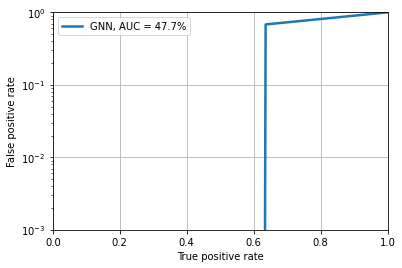

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# create ROC curves
fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test[:,1], y_predict[:,1])
    
# plot ROC curves
plt.figure()
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()